In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np
from numpy.random import uniform as uf
import matplotlib.pyplot as plt
#?matplotlib inline
import pandas as pd
import seaborn as sns
from skl2onnx import convert_sklearn, to_onnx
from skl2onnx.common.data_types import FloatTensorType
import os
from datetime import datetime
from matplotlib import rcParams
from matplotlib.transforms import Bbox

rcParams['savefig.bbox'] = 'tight'

In [2]:
def gen_datacloud(x0, y0, radius, N):

    r = radius * np.random.rand(N)
    theta = 360.0 * np.random.rand(N)

    x = r * np.sin(theta)
    y = r * np.cos(theta)

    x += x0
    y += y0

    return x, y

In [3]:
def gen_dataset(N, rMax, numClouds):

    xs = np.array([])
    ys = np.array([])
    cls = np.array([])

    params = []

    for n in range(numClouds):
        x0 = uf(low=-10, high=10)
        y0 = uf(low=-10, high=10)
        r  = uf(low=1, high=rMax)

        params.append([x0, y0, r])

        x, y = gen_datacloud(x0, y0, r, N)
        cl = np.empty(N, dtype=int)
        cl.fill(n)

        xs = np.concatenate((xs, x))
        ys = np.concatenate((ys, y))
        cls = np.concatenate((cls, cl))

    df = pd.DataFrame(np.hstack((cls[:,None], xs[:,None], ys[:,None])))
    df.columns = ['class', 'x', 'y']
    
    return df, params

In [4]:
def do_training(clf, df):

    df_sampled = df.sample(frac=1) #randomise samples

    target = df_sampled.pop('class')

    X_train, X_test, y_train, y_test = train_test_split(df_sampled, target, test_size=0.33)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    clf.fit(X_train, y_train)

    score = clf.score(X_test, y_test)

    return score, X_train

In [30]:

def store_results(clf, df, score, params, kernel, setName=None):

    if setName == None:
        now = datetime.now()
        setName = now.strftime("data\\%H_%M_%S")
    else:
        setName = "data\\" + setName

    if not os.path.exists(setName):
        os.mkdir(setName)

    # Save image for reference
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect('equal')
    
    df_fig = df.plot(kind='scatter', ax=ax, x='x', y='y', c='class', colormap='viridis', colorbar=False).get_figure()
    plt.axis('off')
    df_fig.savefig(f"{setName}\\vis.png", pad_inches=0)

    # Export ONNX model
    initial_type = [('float_input', FloatTensorType([None, 2]))]
    onx = convert_sklearn(clf, initial_types=initial_type, verbose=False, target_opset={'': 9, 'ai.onnx.ml': 1})
    #onx = to_onnx(clf, X=X_train, verbose=True)
    
    with open(f"{setName}\\model.onnx", "wb") as f:
        f.write(onx.SerializeToString())

    # Export original data parameters as csv
    with open(f"{setName}\\model_params.csv", "w") as f:
        f.write("x_center, y_center, r\n")
        for line in range(len(params)):
            f.write(",".join(map(str, params[line])))
            f.write("\n")

    with open(f"{setName}\\score.txt", "w") as f:
        f.write(f"Score: {str(score)}\n")
        f.write(f"Kernel:{kernel}\n")
        f.write(f"NumBlobs:{len(params)}")


    ## Plot the classifier result
    xx, yy = np.meshgrid(np.arange(-15, 15, 0.1),
                     np.arange(-15, 15, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.5)

    ax.scatter(df['x'], df['y'], c=df['class'], cmap=plt.cm.coolwarm)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_aspect('equal')
    plt.axis('off')
    fig.savefig(f"{setName}\\predicions.png", pad_inches=0)

    return onx

In [63]:
numClouds = 8
df, params = gen_dataset(N=1000, rMax=5, numClouds=numClouds)

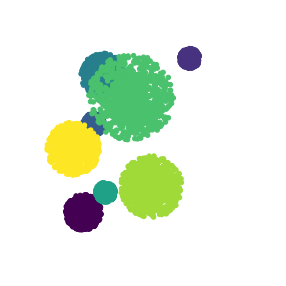

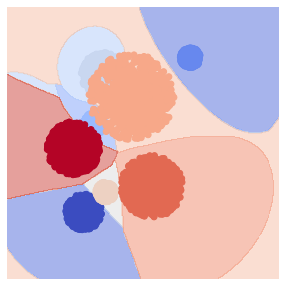

In [64]:
kernel = 'rbf' # [linear, rbf, poly, sigmoid, precomputed]
degree = 1

clf = SVC(kernel=kernel, degree=degree, decision_function_shape='ovo' if numClouds > 2 else 'ovr')

df.columns = ['class', 'x', 'y']
df.head()

score, X_train = do_training(clf, df)
onx = store_results(clf, df, score, params, kernel, setName=f'{numClouds}_{kernel}')

In [ ]:
print(onx)